In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai import *
from fastai.vision import *
from fastai.core import *
import PIL

In [3]:
import colorcet as cc

cmap_grey = cc.cm.linear_grey_0_100_c0

In [4]:
#functions to convert the nn architecture to grayscale input
#from fastai.core import *

def getGrayStats( imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ):
    stats = imagenet_stats
    s=np.asarray(stats)
    st = []
    if len(s.shape)>=2 and s.shape[1] > 1:
        st.append( torch.from_numpy( np.asarray( np.mean(s[0]) ) ).float() )
        st.append( torch.from_numpy( np.asarray( np.sqrt( sum(s[1]*s[1]) / s.shape[1] ) ) ).float() ) 
    return st

#def set_trainable(l, b):apply_leaf(l, lambda m: set_trainable_attr(m,b))
#def set_trainable_attr(m,b):
#    m.trainable=b
#    for p in m.parameters(): p.requires_grad=b
        
def rgbModule2gray(module, rgb2gray=[0.299, 0.587, 0.114] ):
    #Take the average of the weights with: rgb2gray=[1., 1., 1.] ):
    #Or use the grayscale conversion from opencv:Y = 0.299 R + 0.587 G + 0.114 B
    n1,l_rgb = list(module.named_children())[0]
    #print("inputlayer:\nFilter size: ", l_rgb.weight.data.cpu().numpy().shape, "\nLayer definition: ",  str(l_rgb))
    rgb2gray = 3.0*np.asarray(rgb2gray) / sum(rgb2gray)
    #print(f"3*rgb2gray: {rgb2gray}")
          
    #create a 1 channel layer that is the sum of the three rgb channels
    conv_2d_gray = nn.Conv2d(1, out_channels=l_rgb.out_channels, kernel_size=l_rgb.kernel_size, 
                             stride=l_rgb.stride, padding=l_rgb.padding, bias=l_rgb.bias)

    #make np view on the weights and converet the rgb weights to gray weights for each pixel
    rgb_weight  = l_rgb.weight.data.cpu().numpy()
    gray_weight = conv_2d_gray.weight.data.cpu().numpy()
    strength    = np.zeros(rgb_weight.shape[0])
    for i in range( 0, rgb_weight.shape[0] ):
        #sum together the filter filter form each of the rgb channels with separate weighing of each channel
        
        s2 =  (rgb2gray[0]*rgb_weight[i,0] + rgb2gray[1]*rgb_weight[i,1] + rgb2gray[2]*rgb_weight[i,2] )
        #s1 = np.sum( rgb_weight[i], 0 ) 
        #print(f"s1.shape:{s1.shape} s2.shape:{s2.shape}")
        #print(f"s1:{s1[-2:,0]} \ns2:{s2[-2:,0]}")
        gray_weight[i] = s2
        strength[i]    = np.sum(np.abs(gray_weight[i]))

    #sort the filter so the stroomng filter ar placede first (for visualization purposes)
    ix_sort = np.argsort(-strength)
    conv_2d_gray.weight = torch.nn.Parameter( torch.from_numpy(gray_weight[ix_sort]) )

    #freeze the gray layer
    set_trainable(conv_2d_gray,False)            
            
    #extract all but the first layer
    m_children = list(module.children())[1:]
            
    #insert a the new gray first
    m_children.insert(0,conv_2d_gray)
    
    #return the module that takes a grayscale image as input
    module = nn.Sequential( *m_children )
    return module


#Small classs to intercept the instantiation of the model in cnn_create and convert the input filter to grayscale 
class Model2Grayscale:
    def __init__( self, arch ):
        self.arch = arch
    def __call__(self, pretrained): 
        module = self.arch(pretrained)
        module = rgbModule2gray(module)    
        return module    

In [46]:
def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style."
    res = image.cpu().permute(1,2,0).numpy() if image.is_cuda else image.permute(1,2,0).numpy() 
    return res[...,0] if res.shape[2]==1 else res

In [251]:
import matplotlib.gridspec as gridspec
def plotImages( ims ):
    nb    = len(ims)
    ncols = int(np.sqrt(nb))
    nrows = int(math.ceil(nb/ncols))
    fig   = plt.figure(figsize=(12,12))
    gs    = gridspec.GridSpec(nrows, ncols, wspace=0.1, hspace=0.1)
    
    for i in range(nrows):
        for j in range(ncols):
            k  = j + i*ncols
            ax = plt.subplot(gs[k])
            if k < len(ims):
                ax.imshow( ims[k],cmap=cmap_grey  )
            ax.set_xticks([])
            ax.set_yticks([])    
            
def rgbPlot(ax,ims): ax.imshow( ims, cmap=plt.cm.inferno )
def averagePlot(ax,ims):  ax.imshow( np.mean(ims,axis=2 ), cmap=cmap_grey )
def plotImageChannels( ims, fp=rgbPlot ):
    nb    = len(ims)
    ncols = int(np.sqrt(nb))
    nrows = int(math.ceil(nb/ncols))
    fig   = plt.figure(figsize=(8,8))
    gs    = gridspec.GridSpec(nrows, ncols, wspace=0.05, hspace=0.05)
    
    for i in range(nrows):
        for j in range(ncols):
            k  = j + i*ncols
            inner = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[k], wspace=0.05, hspace=0.05)
            

            ax = plt.subplot(inner[0] )
            #ax.imshow( ims[k,:,:], cmap=plt.cm.inferno )
            fp(ax,ims[k] )
            ax.set_xticks([])
            ax.set_yticks([])    
            for l in range(0,3):
                ax = plt.subplot(inner[l+1] )
                #im = ims[k,:,:,l]
                #print(im.shape)
                ax.imshow( ims[k,:,:,l],cmap=cmap_grey )
                ax.set_xticks([])
                ax.set_yticks([])    
                fig.add_subplot(ax)


In [264]:
rgbModel = models.resnet34(pretrained=True)
l1_name,l1_module = list(rgbModel.named_children())[0]
print(f"Name of first layer:{l1_name}\nDefinition of first layer:{l1_module} ")

weights  = l1_module.weight.data.cpu().numpy()

def weigths2images(weights): 
    w_max    = np.max(weights)
    w_min    = np.min(weights)
    #w_mean   = np.mean(weights)
    ims = (weights-w_min)/(w_max-w_min)    
    return np.transpose(ims, (0,2,3,1))

Name of first layer:conv1
Definition of first layer:Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 


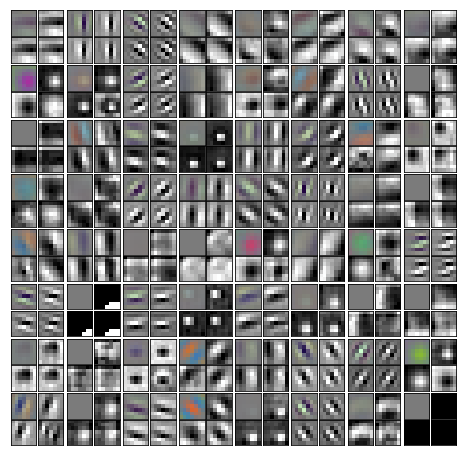

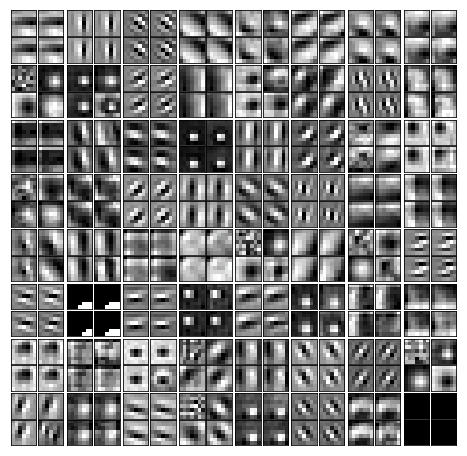

In [265]:
ims = weigths2images(weights)
#plotImages( ims ); plt.show()
plotImageChannels(ims); plt.show()
plotImageChannels(ims,fp=averagePlot); plt.show()

BEFORE: data,shape:(192, 49)
BEFORE: n_samples, n_channels, h, w :64, 3, 7, 7 
pca.singular_values_:49
[1.464914e-05 1.358645e-05 8.479965e-06 8.044474e-06 4.297418e-06]
original shape:    (192, 49)
transformed shape: (192, 49)
inverse transformed shape: (192, 49)
AFTER: ims.shape:(64, 3, 7, 7)


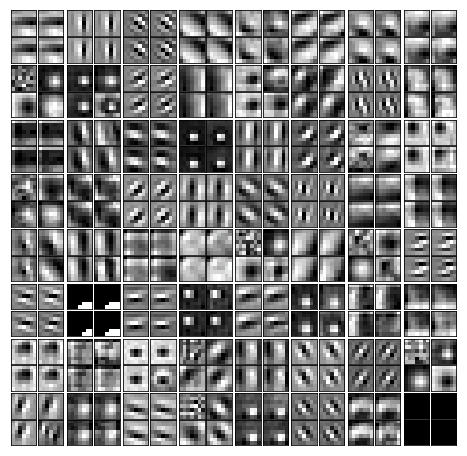

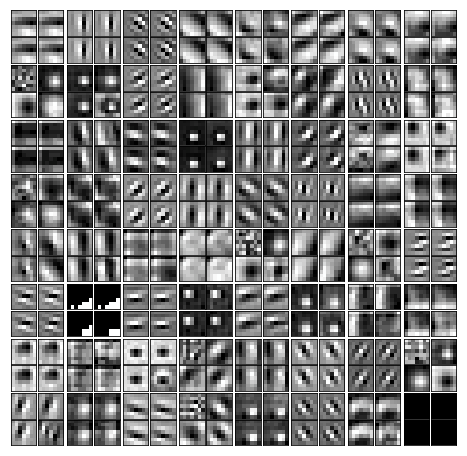

In [269]:
from sklearn.decomposition import PCA
data = np.reshape(weights,(weights.shape[0]*weights.shape[1], -1 ))
print(f"BEFORE: data,shape:{data.shape}")

n_samples, n_channels, h, w = weights.shape
print(f"BEFORE: n_samples, n_channels, h, w :{n_samples}, {n_channels}, {h}, {w} ")

n_components=64 
pca = PCA()
pca.fit(data)
data_pca = pca.transform(data)
data_new = pca.inverse_transform(data_pca)
print(f"pca.singular_values_:{len(pca.singular_values_)}")
#print(pca.components_)
print(pca.explained_variance_[-5:])

print("original shape:   ", data.shape)
print("transformed shape:", data_pca.shape)

print("inverse transformed shape:", data_new.shape)

ims = np.reshape(data_new,(-1, 3, weights.shape[2], weights.shape[3]) )
print(f"AFTER: ims.shape:{ims.shape}")
#plotImages( np.reshape(data, (64,8,8) ) ); plt.show()
#eigenfilters = pca.components_.reshape((n_components, h,w))

#approximation = pca.inverse_transform(data)
#print(f"AFTER: approximation,shape:{eigenfilters.shape}")
#for i in  

plotImageChannels( weigths2images(weights), fp=averagePlot ); plt.show()
plotImageChannels( weigths2images(ims),     fp=averagePlot ); plt.show()

#ims = np.transpose(ims_approximation, (0,2,3,1))
#plotImages( ims ); plt.show()
#plotImageChannels(ims); plt.show()
#plotImageChannels(ims,fp=averagePlot); plt.show()

In [ ]:
plotImages( data ); plt.show()

In [182]:
9408/64/3


49.0

In [322]:
rgb   = np.asarray([.4,.2,.8])

rgb2g   = np.asarray([0.299,0.587,0.114])
g       = np.sum(rgb2g*rgb)
print(f"rgb  :{rgb}")
print(f"g    :{g}")
print(f"np.mean(rgb):{np.mean(rgb)}")

rgb2g_r = 1./rgb2g/3
#rgb2g_r = rgb2g_r / np.sum(rgb2g_r)
print(f"\nrgb2g  :{rgb2g}")
print(f"rgb2g_r:{rgb2g_r}")
print(f"rgb2g *rgb2g_r:{rgb2g * rgb2g_r} ")
print(f"rgb*rgb2g *rgb2g_r:{np.sum(rgb*rgb2g * rgb2g_r)} ")

w_rgb = np.asarray([3.,2.,1.])
#w_rgb = w_rgb/np.sum(w_rgb)

w_g   = w_rgb*rgb2g_r
#w_g   = w_g / np.sum(w_g)
print(f"\nw  :{w_rgb}")
print(f"w_g:{w_g}")
#print(f"w_g:{w_g}")


print(f"s-rgb:{np.sum(w_rgb*rgb)}")
print(f"s-g  :{np.sum(w_g*g)}")


#print(f"s-g:{s_g}")



rgb  :[0.4 0.2 0.8]
g    :0.3282
np.mean(rgb):0.46666666666666673

rgb2g  :[0.299 0.587 0.114]
rgb2g_r:[1.114827 0.567859 2.923977]
rgb2g *rgb2g_r:[0.333333 0.333333 0.333333] 
rgb*rgb2g *rgb2g_r:0.4666666666666667 

w  :[3. 2. 1.]
w_g:[3.344482 1.135718 2.923977]
s-rgb:2.4000000000000004
s-g  :2.4300507454788427
